In [36]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json
import os
from datetime import timedelta, datetime
import pprint

from cerebralcortex.cerebralcortex import CerebralCortex
import matplotlib.pyplot as plt
import numpy as np
import warnings

import util

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
#from cerebralcortex.core.data_manager.raw.file_to_db import FileToDB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def time_diff(ts_list: list)->list:
    """
    Return a series of time differences between consecutive datapoints.
    Return: list[timedelta]
    """
    length = len(ts_list)
    ts_dfs = list()
    for ts1, ts0 in zip(ts_list[1:], ts_list[0:length-1]):
        ts_dfs.append(ts1-ts0)
    return ts_dfs


In [4]:
# All user IDs
USER_IDS = ['00162d05-3248-4b7d-b4f6-8593b4faaa63',
            '03996723-2411-4167-b14b-eb11dfc33124',
            '00ab666c-afb8-476e-9872-6472b4e66b68',
            '03c26210-7c9f-4bf2-b1c2-59d0bd64ffac',
            '022e4ff8-e1af-43dc-b747-862ac83518d2',
            '03ec3750-641a-4039-8b5d-74b485bde1ea',
            '02e82ef0-acb8-4366-8c83-4c3f2f69f7ea',
            '0457f007-211c-4dc3-844e-47d724fece51',
            '038aafca-cc30-47c6-9cbe-5c2cb52d8f04']

pp = pprint.PrettyPrinter(indent=2)

# Load CerebralCortex Configurations
CC = CerebralCortex("/home/mperf/sandeep/CerebralCortex-DockerCompose/cc_config_file/cc_vagrant_configuration.yml")

# Type of sensor streams

In [5]:
all_streams = list(CC.get_user_streams_metadata(USER_IDS[1]))
phone_streams = list()
motionsense_streams = list()
beacon_streams = list()

for key in all_streams:
    if'org.md2k.phonesensor--PHONE' in key:
        phone_streams.append(key)
    elif 'org.md2k.motionsense' in key:
        motionsense_streams.append(key)
    elif 'org.md2k.beacon--BEACON' in key:
        beacon_streams.append(key)
phone_streams = sorted(phone_streams)
motionsense_streams = sorted(motionsense_streams)
pp.pprint(phone_streams)
pp.pprint(motionsense_streams)
pp.pprint(beacon_streams)

[ 'ACCELEROMETER--org.md2k.phonesensor--PHONE',
  'ACTIVITY_TYPE--org.md2k.phonesensor--PHONE',
  'AMBIENT_LIGHT--org.md2k.phonesensor--PHONE',
  'AMBIENT_TEMPERATURE--org.md2k.phonesensor--PHONE',
  'AMBIENT_TEMPERATURE_SUMMARY_DAY--org.md2k.phonesensor--PHONE',
  'AMBIENT_TEMPERATURE_SUMMARY_HOUR--org.md2k.phonesensor--PHONE',
  'AMBIENT_TEMPERATURE_SUMMARY_MINUTE--org.md2k.phonesensor--PHONE',
  'AMBIENT_TEMPERATURE_SUMMARY_TOTAL--org.md2k.phonesensor--PHONE',
  'BATTERY--org.md2k.phonesensor--PHONE',
  'GEOFENCE--LIST--org.md2k.phonesensor--PHONE',
  'GYROSCOPE--org.md2k.phonesensor--PHONE',
  'PRESSURE--org.md2k.phonesensor--PHONE',
  'PROXIMITY--org.md2k.phonesensor--PHONE',
  'PROXIMITY_SUMMARY_DAY--org.md2k.phonesensor--PHONE',
  'PROXIMITY_SUMMARY_HOUR--org.md2k.phonesensor--PHONE',
  'PROXIMITY_SUMMARY_MINUTE--org.md2k.phonesensor--PHONE',
  'PROXIMITY_SUMMARY_TOTAL--org.md2k.phonesensor--PHONE',
  'STEP_COUNT--org.md2k.phonesensor--PHONE',
  'STEP_COUNT_SUMMARY_DAY--org.md2k

/home/mperf/sandeep/CerebralCortex/cerebralcortex/cerebralcortex.py:180: DeprecationWarning: PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.
  warnings.warn("PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.", DeprecationWarning)


# Formulate hypothesis

## Visualize BLE Beacon Data Streams

/home/mperf/sandeep/CerebralCortex/cerebralcortex/cerebralcortex.py:189: DeprecationWarning: PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.
  warnings.warn("PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.", DeprecationWarning)


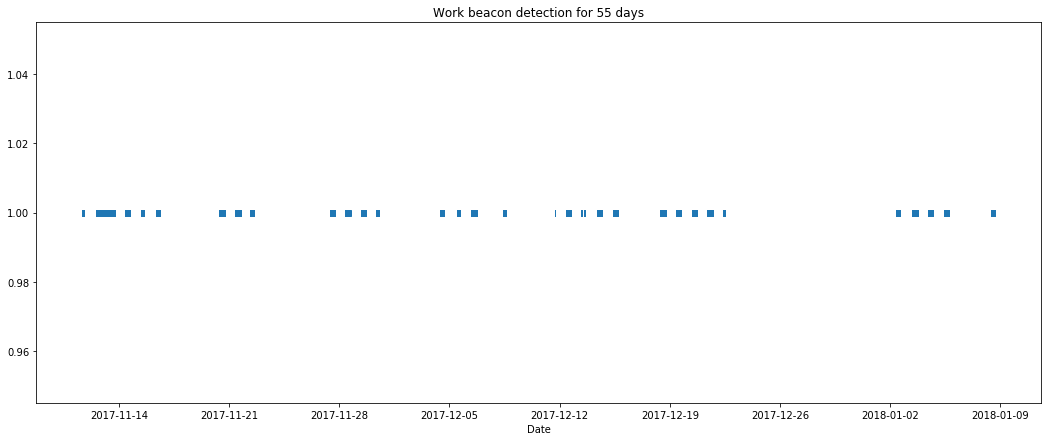

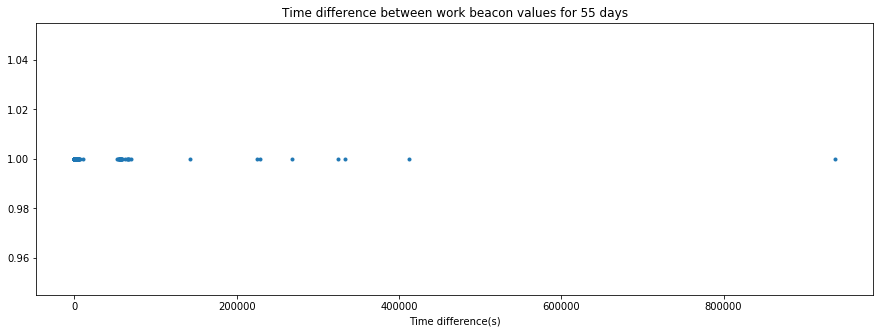

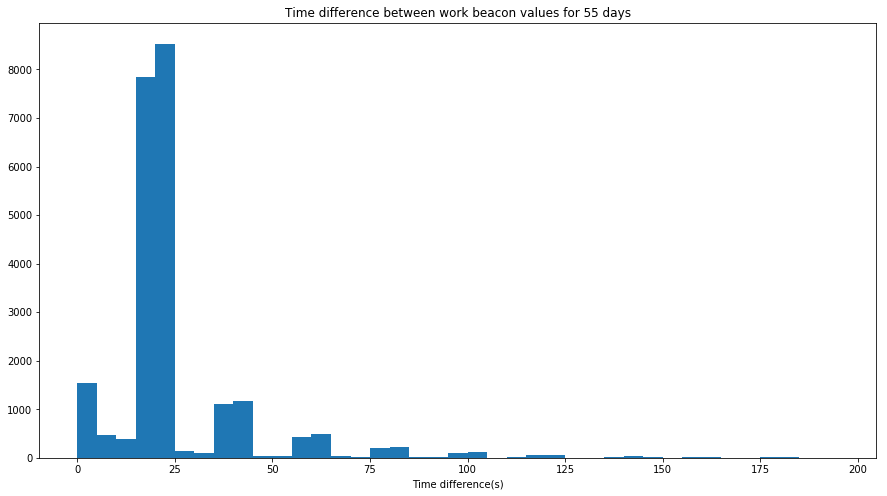

In [6]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())

# Get beacon stream at work place
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])
if work_bcn_stream_labels:
    work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
    # List for all timestamps
    ts_list = list()

    # List for all time difference in seconds
    tdf_sec = list()

    # Number of days
    stream_day_cnt = 0

    # Get all timestamps (Datetime obj) in a list
    for stream_id in work_bcn_stream['stream_ids']:
        stream_days = CC.get_stream_days(stream_id)
        stream_day_cnt += len(stream_days)
        for i, stream_day in enumerate(stream_days):
            ds = CC.get_stream(stream_id, user_id, stream_day)
            ts_list += [dp.start_time + timedelta(milliseconds=dp.offset) for dp in ds.data]

    tdf_sec = [tdf.total_seconds() for tdf in time_diff(ts_list)]


    plt.figure(figsize=(18,7))
    plt.plot(ts_list, np.ones(len(ts_list)), '|')
    plt.title('Work beacon detection for %d days'%stream_day_cnt)
    plt.xlabel('Date')

    plt.figure(figsize=(15,5))
    plt.plot(tdf_sec, np.ones(len(tdf_sec)), '.')
    plt.title('Time difference between work beacon values for %d days'%stream_day_cnt)
    plt.xlabel('Time difference(s)')

    plt.figure(figsize=(15,8))
    hist_results = plt.hist(tdf_sec, bins=np.arange(0,40)*5)
    plt.title('Time difference between work beacon values for %d days'%stream_day_cnt)
    plt.xlabel('Time difference(s)')
    

## Visualize beacon distance

/home/mperf/sandeep/CerebralCortex/cerebralcortex/cerebralcortex.py:189: DeprecationWarning: PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.
  warnings.warn("PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.", DeprecationWarning)


1.347599314849728
0.7120772412581653


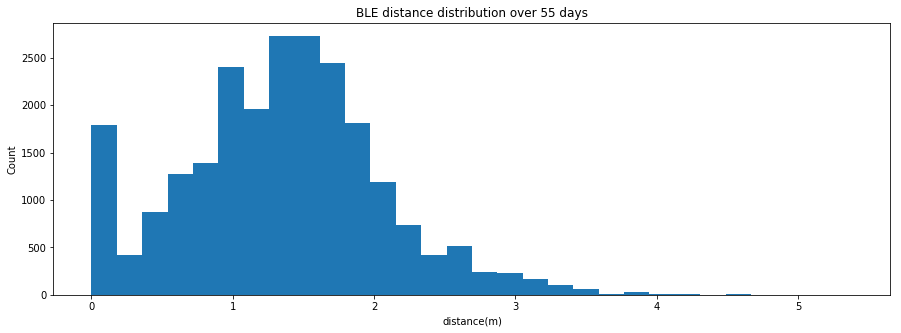

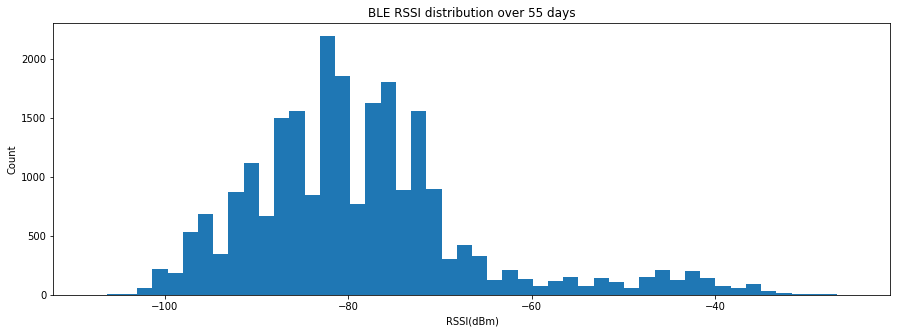

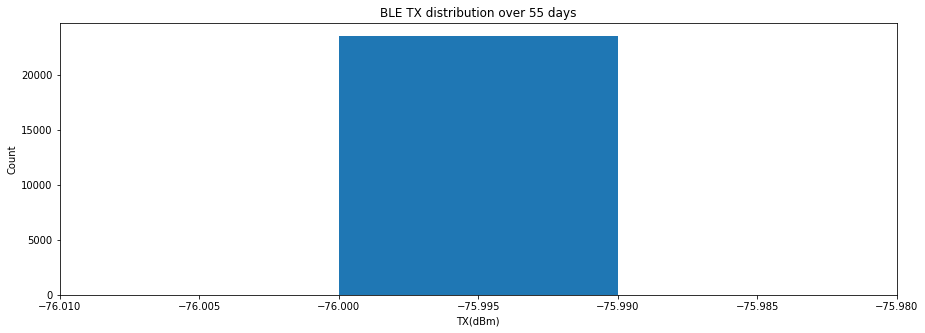

In [11]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())

# Get beacon stream at work place
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])
if work_bcn_stream_labels:
    work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
    # Get all distance values in a list
    dist_list = list()
    rssi_list = list()
    tx_list = list()
    for stream_id in work_bcn_stream['stream_ids']:
        stream_days = CC.get_stream_days(stream_id)
        for i, stream_day in enumerate(stream_days):
            ds = CC.get_stream(stream_id, user_id, stream_day)
            dist_list += [dp.sample[0] for dp in ds.data]
            rssi_list += [dp.sample[1] for dp in ds.data]
            tx_list += [dp.sample[2] for dp in ds.data]
            ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in ds.data]

plt.figure(figsize=(15,5))
plt.hist(dist_list, bins=30)
plt.xlabel('distance(m)')
plt.ylabel('Count')
plt.title('BLE distance distribution over 55 days')


plt.figure(figsize=(15,5))
plt.hist(rssi_list, bins=50)
plt.xlabel('RSSI(dBm)')
plt.ylabel('Count')
plt.title('BLE RSSI distribution over 55 days')

plt.figure(figsize=(15,5))
plt.hist(tx_list, bins=100)
plt.xlabel('TX(dBm)')
plt.ylabel('Count')
plt.xlim((-76.01, -75.98))
plt.title('BLE TX distribution over 55 days')

print(np.mean(dist_list))
print(np.std(dist_list))

## Correlation between user activity type and work BLE beacons

/home/mperf/sandeep/CerebralCortex/cerebralcortex/cerebralcortex.py:189: DeprecationWarning: PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.
  warnings.warn("PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.", DeprecationWarning)


Text(0.5,1,'Work BLE vs activity type\n 2017-11-14 12:00-14:30')

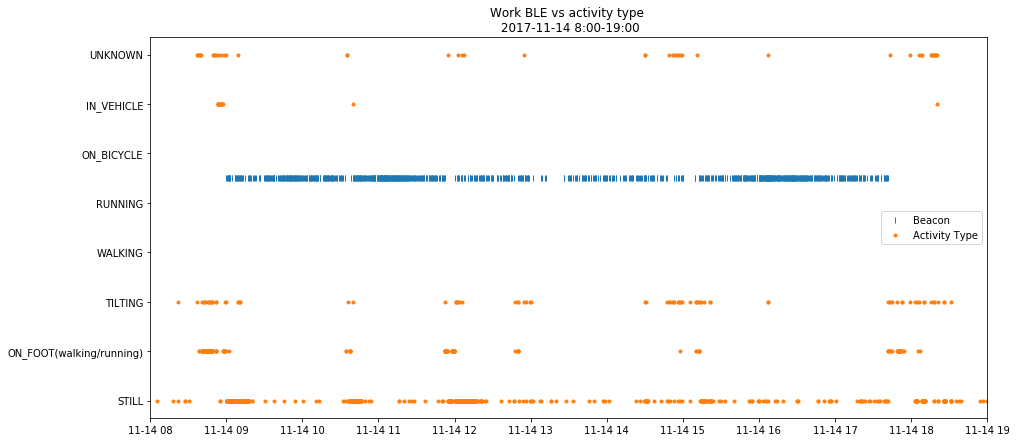

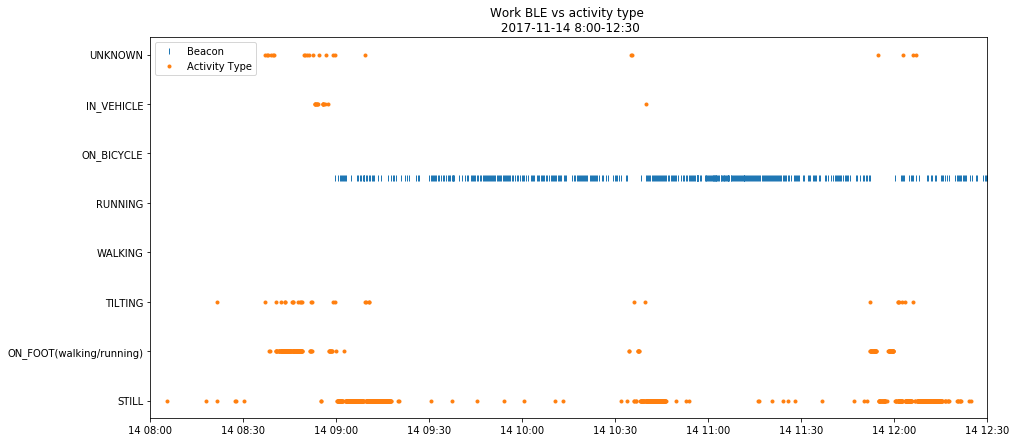

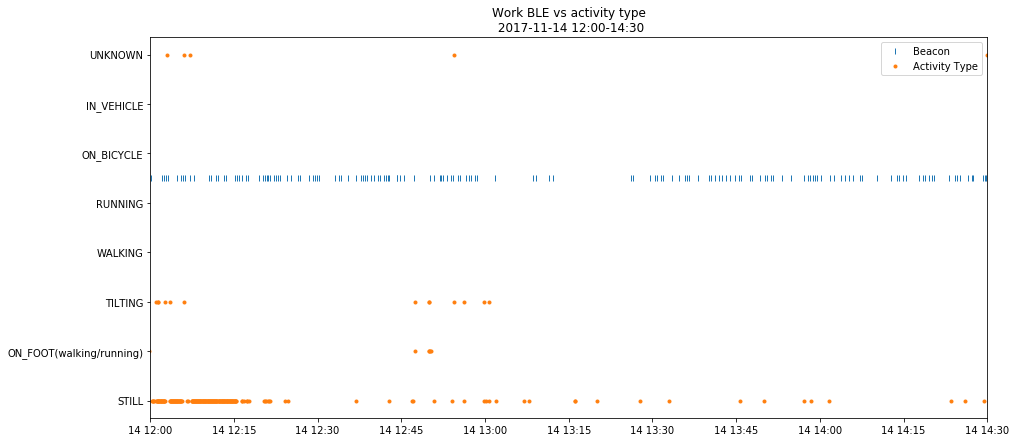

In [30]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())

# Get stream labels
act_type_label = 'ACTIVITY_TYPE--org.md2k.phonesensor--PHONE'
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])

# Get beacon stream and activity type stream
work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
act_type_stream = user_streams[act_type_label]


work_bcn_stream_id = work_bcn_stream['stream_ids'][0]
work_bcn_data = CC.get_stream(work_bcn_stream_id, user_id, '20171114').data + CC.get_stream(work_bcn_stream_id, user_id, '20171115').data
# Get all timestamps
work_bcn_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in work_bcn_data]


        
act_type_stream_id = act_type_stream['stream_ids'][0]
act_type_data = CC.get_stream(act_type_stream_id, user_id, '20171114').data + CC.get_stream(act_type_stream_id, user_id, '20171115').data
# Get all timestamps
act_type_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in act_type_data]   
act_type_list = [dp.sample[0] for dp in act_type_data]

plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 4.5*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(act_type_ts_list, act_type_list, '.', label='Activity Type')
activity_type_yticks = ['STILL', 
                        'ON_FOOT(walking/running)', 
                        'TILTING', 
                        'WALKING', 
                        'RUNNING', 
                        'ON_BICYCLE', 
                        'IN_VEHICLE', 
                        'UNKNOWN']
plt.yticks(np.arange(0, 8), activity_type_yticks)
plt.xlim((datetime(2017,11,14,8,0),datetime(2017,11,14,19)))
plt.legend()
plt.title("Work BLE vs activity type \n 2017-11-14 8:00-19:00")



plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 4.5*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(act_type_ts_list, act_type_list, '.', label='Activity Type')
activity_type_yticks = ['STILL', 
                        'ON_FOOT(walking/running)', 
                        'TILTING', 
                        'WALKING', 
                        'RUNNING', 
                        'ON_BICYCLE', 
                        'IN_VEHICLE', 
                        'UNKNOWN']
plt.yticks(np.arange(0, 8), activity_type_yticks)
plt.xlim((datetime(2017,11,14,8,0),datetime(2017,11,14,12,30)))
plt.legend()
plt.title("Work BLE vs activity type \n 2017-11-14 8:00-12:30")



plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 4.5*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(act_type_ts_list, act_type_list, '.', label='Activity Type')
activity_type_yticks = ['STILL', 
                        'ON_FOOT(walking/running)', 
                        'TILTING', 
                        'WALKING', 
                        'RUNNING', 
                        'ON_BICYCLE', 
                        'IN_VEHICLE', 
                        'UNKNOWN']
plt.yticks(np.arange(0, 8), activity_type_yticks)
plt.xlim((datetime(2017,11,14,12,0),datetime(2017,11,14,14,30)))
plt.legend()
plt.title("Work BLE vs activity type\n 2017-11-14 12:00-14:30")

## Correlation between light intensity and work BLE beacons

/home/mperf/sandeep/CerebralCortex/cerebralcortex/cerebralcortex.py:189: DeprecationWarning: PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.
  warnings.warn("PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.", DeprecationWarning)


Text(0.5,1,'Work BLE vs light intensity \n 2017-11-15 8:00-19:00')

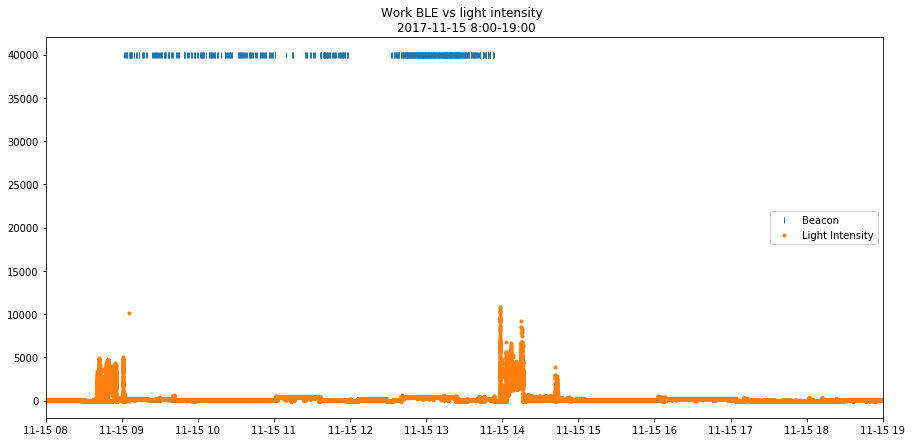

In [27]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())

# Get stream labels
light_label = 'AMBIENT_LIGHT--org.md2k.phonesensor--PHONE'
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])

# Get beacon stream and activity type stream
work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
light_stream = user_streams[light_label]


work_bcn_stream_id = work_bcn_stream['stream_ids'][0]
work_bcn_data = CC.get_stream(work_bcn_stream_id, user_id, '20171115').data + CC.get_stream(work_bcn_stream_id, user_id, '20171116').data
# Get all timestamps
work_bcn_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in work_bcn_data]


        
light_stream_id = light_stream['stream_ids'][0]
light_data = CC.get_stream(light_stream_id, user_id, '20171115').data + CC.get_stream(light_stream_id, user_id, '20171116').data
# Get all timestamps
light_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in light_data]   
light_list = [dp.sample[0] for dp in light_data]

plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 40000*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(light_ts_list, light_list, '.', label='Light Intensity')

plt.xlim((datetime(2017,11,15,8,0),datetime(2017,11,15,19)))
plt.legend()
plt.title("Work BLE vs light intensity \n 2017-11-15 8:00-19:00")



## Correlation between proximity and work BLE beacons

/home/mperf/sandeep/CerebralCortex/cerebralcortex/cerebralcortex.py:189: DeprecationWarning: PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.
  warnings.warn("PLEASE USE stream_ids KEY IN DICT OBJECT TO GET ALL STREAM IDS OF A STREAM NAME. Identifier key will be removed in CerebralCortex version 2.2.4.", DeprecationWarning)


Text(0.5,1,'Work BLE vs light intensity \n 2017-11-15 8:00-19:00')

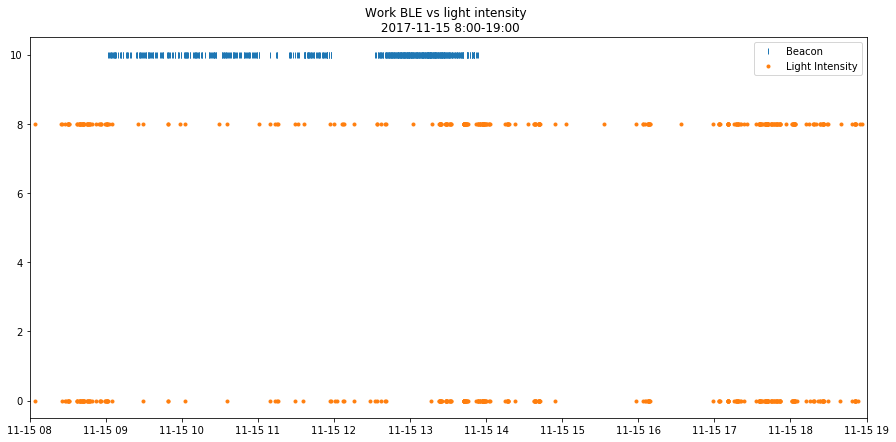

In [33]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())

# Get stream labels
light_label = 'PROXIMITY--org.md2k.phonesensor--PHONE'
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])

# Get beacon stream and activity type stream
work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
light_stream = user_streams[light_label]


work_bcn_stream_id = work_bcn_stream['stream_ids'][0]
work_bcn_data = CC.get_stream(work_bcn_stream_id, user_id, '20171115').data + CC.get_stream(work_bcn_stream_id, user_id, '20171116').data
# Get all timestamps
work_bcn_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in work_bcn_data]

        
light_stream_id = light_stream['stream_ids'][0]
light_data = CC.get_stream(light_stream_id, user_id, '20171115').data + CC.get_stream(light_stream_id, user_id, '20171116').data
# Get all timestamps
light_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in light_data]   
light_list = [dp.sample[0] for dp in light_data]

plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 10*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(light_ts_list, light_list, '.', label='Light Intensity')

plt.xlim((datetime(2017,11,15,8,0),datetime(2017,11,15,19)))
plt.legend()
plt.title("Work BLE vs proximity \n 2017-11-15 8:00-19:00")



## Correlation between step count and work BLE beacons

Text(0.5,1,'Work BLE vs step count \n 2017-11-14 8:00-19:00')

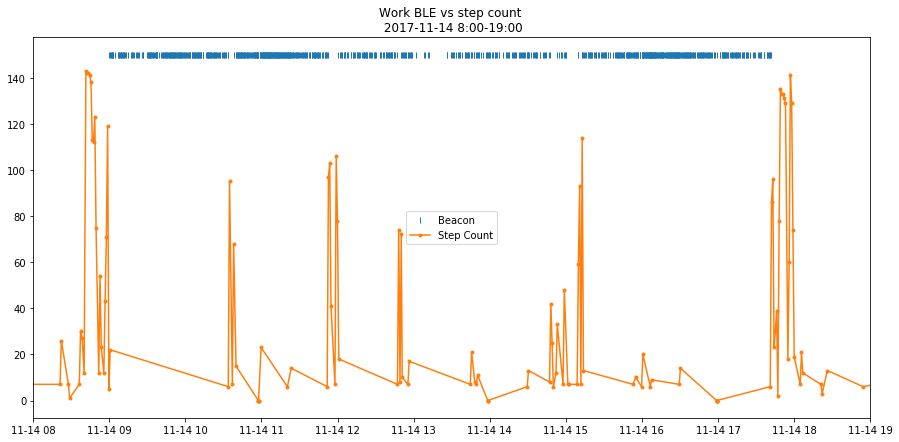

In [44]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())

# Get stream labels
step_cnt_label = 'STEP_COUNT--org.md2k.phonesensor--PHONE'
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])

# Get beacon stream and step count stream
work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
step_cnt_stream = user_streams[step_cnt_label]


# Get all timestamps
stream_id = work_bcn_stream['stream_ids'][0]
data = CC.get_stream(work_bcn_stream_id, user_id, '20171114').data \
       + CC.get_stream(work_bcn_stream_id, user_id, '20171115').data
work_bcn_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in data]

        
stream_id = step_cnt_stream['stream_ids'][0]
data = CC.get_stream(light_stream_id, user_id, '20171114').data \
       + CC.get_stream(light_stream_id, user_id, '20171115').data
step_cnt_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in data]   
step_cnt_list = [dp.sample[0] for dp in data]

plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 150*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(step_cnt_ts_list, step_cnt_list, '.-', label='Step Count')

plt.xlim((datetime(2017,11,14,8,0),datetime(2017,11,14,19)))
plt.legend()
plt.title("Work BLE vs step count \n 2017-11-14 8:00-19:00")



## Correlation between wristband accelerometer and work BLE beacons

([<matplotlib.axis.YTick at 0x7f96fb6909b0>,
 <a list of 8 Text yticklabel objects>)

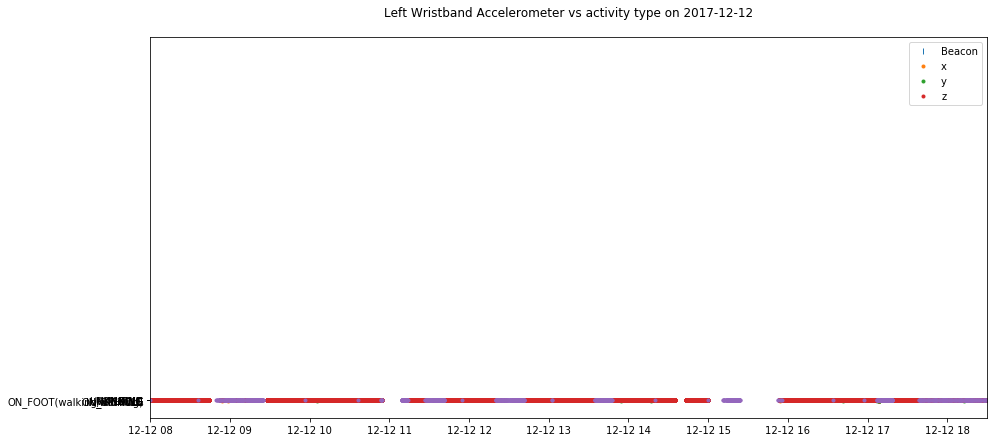

In [56]:
user_id = USER_IDS[1]
user_streams = CC.get_user_streams(user_id)
stream_labels = list(user_streams.keys())
#pp.pprint(stream_labels)

# Get stream labels
accel_label = 'ACCELEROMETER--org.md2k.motionsense--MOTION_SENSE_HRV--LEFT_WRIST'
work_bcn_stream_labels = util.extract_matched_labels(stream_labels, ['BEACON', 'WORK'])

# Get beacon stream and left wrist accel stream
work_bcn_stream = user_streams[work_bcn_stream_labels[0]]
accel_stream = user_streams[accel_label]


stream_id = work_bcn_stream['stream_ids'][0]
data = CC.get_stream(stream_id, user_id, '20171212').data + CC.get_stream(stream_id, user_id, '20171213').data
work_bcn_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in data]


        
stream_id = accel_stream['stream_ids'][0]
data = CC.get_stream(stream_id, user_id, '20171212').data + CC.get_stream(stream_id, user_id, '20171213').data
accel_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in data]   
accel_x = [dp.sample[0] for dp in data]
accel_y = [dp.sample[1] for dp in data]
accel_z = [dp.sample[2] for dp in data]



act_type_stream_id = act_type_stream['stream_ids'][1]
data = CC.get_stream(act_type_stream_id, user_id, '20171212').data \
    + CC.get_stream(act_type_stream_id, user_id, '20171213').data
# Get all timestamps
act_type_ts_list = [dp.start_time + timedelta(milliseconds=dp.offset) for dp in data]   
act_type_list = [dp.sample[0] for dp in data]



plt.figure(figsize=(15,7))
plt.plot(work_bcn_ts_list, 4.5*np.ones(len(work_bcn_ts_list)), '|', label='Beacon')
plt.plot(accel_ts_list, accel_x, '.', label='x')
plt.plot(accel_ts_list, accel_y, '.', label='y')
plt.plot(accel_ts_list, accel_z, '.', label='z')


plt.xlim((datetime(2017,12,12,8,0),datetime(2017,12,12,18,30)))
plt.legend()
plt.title("Left Wristband Accelerometer vs activity type on 2017-12-12\n")


plt.plot(act_type_ts_list, act_type_list, '.', label='Activity Type')
activity_type_yticks = ['STILL', 
                        'ON_FOOT(walking/running)', 
                        'TILTING', 
                        'WALKING', 
                        'RUNNING', 
                        'ON_BICYCLE', 
                        'IN_VEHICLE', 
                        'UNKNOWN']
plt.yticks(np.arange(0, 8), activity_type_yticks)


# Goal

1. Predict whether the user is near the desk. ====> Possible prediction choice [True, False, Uncertain]   
2. Groundtruth information is obtained from BLE Beacon deployed at working place.

# Summary   
  
## Available sensor streams from phone:  
* accelerometer (16.0Hz)
* activity type (1.0Hz)
* ambient light (16.0Hz) 
* ambient temperature (1.0Hz)
* beacon (1.0Hz)
* battery (1.0Hz)
* geofence ()
* gyroscope (16.0Hz)
* pressure (6.0Hz)
* proximity (ON_CHANGE)
* step_count (1.0Hz)
* touch_screen (ON_CHANGE)

## Available sensor streams from wristbands:
* accelerometer (16.0Hz)
* battery 
* LED
* gyroscope (16.0Hz)
* sequence number

## Observation of BLE beacons
* The metadata claims the frequency of beacon data is 1Hz.
* After plotting the distribution of time difference of consecutive beacon data points, more that 69.5% of all time differences are around 19~25s.
* Over 55 days, the mean distance of BLE data is 1.3 meters. The standard deviation is about 0.7 meters. The threshold value for BLE data can be set to one std above mean. Thus, the threshold value is 2.0 meters.
* For beacons with distances smaller than 2.0 meters, they can be considered as indication to user being at working desk.
* How does distance value in beacon data calculated?

## Extract groundtruth information from BLE
* Consecutive beacons with time difference less than 25s can be considered as a sequnce of indications that users do not leave the working desks.
* Form groundtruth streams



## Relationship between activity type and BLE beacons

* Activity type should have 1Hz sampling rate based on metadata but the actual data bases on the change of user activity. So the activity type data need to be introperlated.

* When the phone captures a stream of working BLE beacons(a dense stream), the activity type stream contains mainly STILL.
* At the edges of a dense stream, the activity type tends to be ON_FOOT, TILTING, and UNKNOWN.
* Sequencce of activities to be captured:  
on_foot (a user approaches a desk) -->  
tilting (possibly the user is putting down the phone) -->  
still (the cell phone is kept still: the user is at desk) -->  
tilting (possibly the user stands up and picks up the phone) -->  
on_foot (the user leaves the desk)

## Relationship between light intensity and BLE beacons
* Do not see obvious connection.

## Relationship between proximity and BLE beacons
* Do not see obvious connection.


## Relationship between step count and BLE beacons
* The step count increases when there is on work beacon data.



## Time Window as a hyperparameter
* 30 seconds
* 20 seconds
* 10 seconds

## Model Selection
* HMM (Observed Variable: acitivity types(0-7) Hidden Variable: at working desk/not at working desk)
* Neural Network
* CNN
* LSTM

## Feature Selection
- ### Activity Type
    - Raw data
- ### Phone Accelerometer
    - Raw data
    - Mean
    - Variance
    - Max
    - Min
- ### Phone Gyroscope
    - Raw data
    - Mean
    - Variance
    - Max
    - Min
- ### Wristband Accelerometer
    - Raw data
    - Mean
    - Variance
    - Max
    - Min
- ### Wristband Gyroscope
    - Raw data
    - Mean
    - Variance
    - Max
    - Min

In [1]:
import sys
print('\n'.join(sys.path))


/home/mperf/sandeep/Codes
/home/mperf/sandeep/CerebralCortex
/home/mperf/anaconda3/envs/myenv/lib/python36.zip
/home/mperf/anaconda3/envs/myenv/lib/python3.6
/home/mperf/anaconda3/envs/myenv/lib/python3.6/lib-dynload
/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages
/home/mperf/anaconda3/envs/myenv/lib/python3.6/site-packages/IPython/extensions
/home/mperf/.ipython
